In [32]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import os

from models import Classifier, MLP, Classifier_2
from helpers import model_to_list, plot_decision_boundary, list_to_model
from datasets import ModelParamsDataset

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Current device:", device)

Current device: cuda:0


In [33]:
dataset = pd.read_csv("Datasets/two_angles.csv")

In [61]:
dataset.iloc[0, :-1].to_numpy().shape

(151,)

In [10]:
# DATASET CREATION
angles = [0, 90]

models_path = "models"
models_per_angle = 2000
train_set_ratio = 0.9

x_train = []
y_train = []

x_test = []
y_test = []

saved_parameters = os.listdir("models/two_angles")
for i, parameters in enumerate(saved_parameters):
    angle = int(parameters.split("_")[1])
    if(angle in angles):
        model = MLP()
        model.load_state_dict(torch.load(os.path.join(models_path,"two_angles", parameters)))
        if(i % models_per_angle < train_set_ratio * models_per_angle):
            x_train.append(model_to_list(model))
            y_train.append(int(angle/90))
        else:
            x_test.append(model_to_list(model))
            y_test.append(int(angle/90))

    
print(f"Loaded {len(x_train)} models for training and {len(x_test)} models for testing.")

# Create a dataset and dataloader
dataset_train = ModelParamsDataset(x_train, y_train)
dataset_test = ModelParamsDataset(x_test, y_test)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=False)

Loaded 3600 models for training and 400 models for testing.


  0%|          | 0/100 [00:00<?, ?it/s]

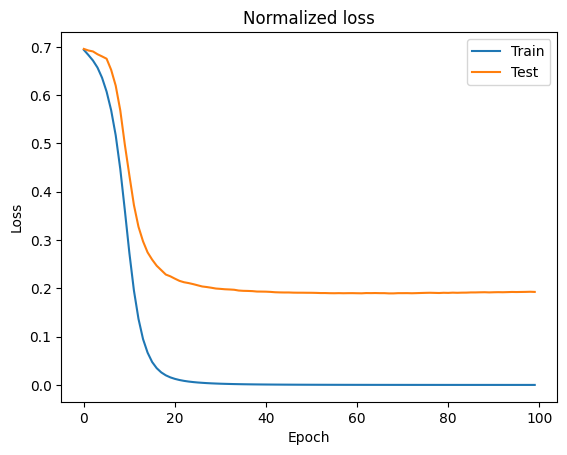

In [22]:
# TRAINING

torch.manual_seed(42)

# Hyperparameters
model = Classifier_2()
model.to(device)
epochs = 100
learning_rate = 0.0001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Logging
total_losses_train = []
total_losses_test = []

# Training
for epoch in tqdm(range(epochs)):
    total_loss = 0
    model.train()
    for X, y in dataloader_train:
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X.float())
        y = torch.nn.functional.one_hot(y, num_classes=2).float()
        loss = criterion(y_pred, y)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    total_losses_train.append(total_loss)

    total_loss = 0
    model.eval()
    for X, y in dataloader_test:
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X.float())
        y = torch.nn.functional.one_hot(y, num_classes=2).float()
        loss = criterion(y_pred, y)
        total_loss += loss.item()
    
    total_losses_test.append(total_loss)


# Plot the losses
total_losses_train = np.array(total_losses_train)/len(dataloader_train)
total_losses_test = np.array(total_losses_test)/len(dataloader_test)

plt.plot(total_losses_train, label="Train")
plt.plot(total_losses_test, label="Test")
plt.legend()
plt.title("Normalized loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [29]:
total_correct = 0
for X, y in dataloader_test:
    X = X.to(device)
    y = y.to(device)
    y_pred = model(X.float())
    # Accuracy
    y_pred = torch.argmax(y_pred, dim=1)
    correct = (y_pred == y).sum()
    total_correct += correct

accuracy = total_correct / len(dataset_test) * 100
print(f"Accuracy: {accuracy}%")

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [25]:
import sklearn.datasets

model = MLP()
model.load_state_dict(torch.load("models/model_0_12.pth"))
weights = model_to_list(model)
# temp_1 = weights[0]
# temp_2 = weights[1]
# weights[0] = weights[2]
# weights[1] = weights[3]
# weights[2] = temp_1
# weights[3] = temp_2
model = list_to_model(weights)
X,y = sklearn.datasets.make_moons(n_samples=1000, noise=0.1, random_state=42)

# Normalization
X = (X - X.mean(axis=0)) / X.std(axis=0)

plot_decision_boundary(model, X, y)

FileNotFoundError: [Errno 2] No such file or directory: 'models/model_0_12.pth'